In [1]:
from __future__ import print_function, division
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# (Non)Linear IA Models

In [2]:
from linear_alingment_models import LinearAlignmentModel as LA
from linear_alingment_models import NonLinearAlignmentModel as NLA
from hrh_model import HRH

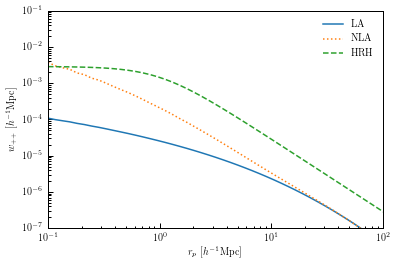

In [3]:
r = np.logspace(-1,2.2,50)

la = LA() 
xi_1 = la.ii_plus(r)

nla = NLA() 
xi_2 = nla.ii_plus(r)

hrh = HRH()
xi_3 = hrh.ee_3d(r)

plt.figure()
l1, = plt.plot(r, 10*xi_1, '-')
l2, = plt.plot(r, 10*xi_2, ':')
l3, = plt.plot(r, xi_3, '--')
plt.yscale('log')
plt.xscale('log')
plt.ylim([10**(-7),10**(-1)])
plt.xlim([0.1,100])
plt.xlabel(r'$r_p~[h^{-1}{\rm Mpc}]$')
plt.ylabel(r'$w_{++}~[h^{-1}{\rm Mpc}]$')
plt.legend([l1, l2, l3],['LA', 'NLA', 'HRH'], frameon=False, loc='upper right', fontsize=10)
plt.show()